In [283]:
import numpy as np
class DecisionTree:    
    def __init__(self,depth_limit=5):
        self.depth_limit = depth_limit
        self.childs = [] # tree structure, cointains indices of nodes
        self.feature_index = [] # index of feature using in splitting 
        self.feature_bound = [] # boundary value of current feature for node 
        self.leaf_target = [] # answer for leaf
        
    def _append_nodes(self,quantity):
        for i in range(quantity):
            self.childs.append([])
            self.feature_index.append(-1)
            self.feature_bound.append(-1)
            self.leaf_target.append(-1)
        
    def _is_leaf(self, index) :
        if len(self.childs[index]) == 0:
            return True
        return False

    #using MSE metric
    def _split(self,l_index, r_index, f_index, f_bound,real_split=False):
        sorted_data = np.array(sorted(self.train_data[l_index:r_index],
                    key=lambda x: x[f_index]))
        
        if real_split:
            self.train_data[l_index:r_index] = sorted_data
            
        #try to find where to split sorted data
        bound_position = len(sorted_data)
        for i in range(len(sorted_data)):
            if sorted_data[i][f_index] > f_bound:
                bound_position = i
                break
                    
        #make split and calc MSE in childs
        left_target = sorted_data[:bound_position][:,-1]
        right_target = sorted_data[bound_position:][:,-1]
        HL = np.var(left_target)
        HR = np.var(right_target)
        L = len(left_target)
        R = len(right_target)
        Q = len(sorted_data)
        
        # return result of splitting 
        if real_split:
            return bound_position
        
        #return quality of splitting
        return L/Q * HL + R/Q * HR
        
    def _calc_split_metric(self,l_index, r_index, f_index, f_bound):
        return self._split(l_index, r_index, f_index, f_bound)
        
    def _build_node(self,node_id,l_index,r_index,depth):
        #stop splitting to make leaf
        if depth >= self.depth_limit or r_index - l_index < 2:
            #average value of leaf's targets
            self.leaf_target[node_id] = np.mean((self.train_data[l_index:r_index])[:,-1])
            return
        
        # try to find best split 
        best_metric = 1e18
        best_f_index = 0
        best_bound = 0
        for f_index in range(len(self.train_data[0]) - 1):
                l_bound = np.min(self.train_data[:,f_index])
                r_bound = np.max(self.train_data[:,f_index])
                step = (r_bound - l_bound) / 100.0
                for bound in np.arange(l_bound,r_bound + step,step=step):
                    metric = self._calc_split_metric(l_index,r_index,f_index,bound)
                    #update best result
                    if best_metric > metric:
                        best_metric = metric
                        best_bound = bound
                        best_f_index = f_index

        if best_metric == 1e18:
            assert r_index - l_index >= 1
            self.leaf_target[node_id] = np.mean(self.train_data[l_index:r_index][:,-1])
            return
        
        split_position = self._split(l_index,r_index,best_f_index,best_bound,real_split=True)

        #can't create appropriate division
        if split_position == r_index - l_index:
            self.leaf_target[node_id] = np.mean(self.train_data[l_index:r_index][:,-1])
            return
            
        child_l = len(self.childs)
        child_r = child_l + 1
        self._append_nodes(2)
        self.childs[node_id] = [child_l,child_r]
        self.feature_index[node_id] = best_f_index
        self.feature_bound[node_id] = best_bound
        
        self._build_node(child_l,l_index,split_position + l_index,depth+1)
        self._build_node(child_r,split_position + l_index,r_index,depth+1)
        
    def _build(self):
        l_index = 0
        r_index = len(self.train_data)
        
        #add root to tree
        self._append_nodes(1)
        #build recursive 
        self._build_node(0,l_index,r_index,0)
        #clear useless data
#         self.train_data = []
        
    def fit(self,features,target):
        #copy data and join features and target
        tmp = features.copy()
        self.train_data = []
        for i in range(len(tmp)):
            self.train_data.append(np.concatenate((tmp[i], [target[i]])))
        self.train_data = np.array(self.train_data)
        self._build()
        
    #PREDICTION
    def _find(self,node_id,test_features):
        if self._is_leaf(node_id) :
            return self.leaf_target[node_id]
        
        feature_id = self.feature_index[node_id]
        bound = self.feature_bound[node_id]
        test_value = test_features[feature_id]
        if test_value <= bound:
            #go down to the LEFT child
            return self._find(self.childs[node_id][0],test_features)
        else :
            #go down to the RIGHT child
            return self._find(self.childs[node_id][1],test_features)
        
    def predict(self,test_features):
        return [self._find(0,feature) for feature in test_features]

Протестируем...

In [303]:
from sklearn import datasets
from sklearn import cross_validation
import matplotlib.pyplot as plt
%matplotlib inline
boston = datasets.load_boston()
features = boston['data']
target = boston['target']

In [277]:
train_data, test_data, train_labels, test_labels = cross_validation.train_test_split(features, target, 
                                                                                     test_size = 0.25)

In [301]:
my_var = []
classic_var = []
for n in range(1,9):
    myTree = DecisionTree(depth_limit=n)
    myTree.fit(train_data,train_labels)
    res = myTree.predict(test_data) - test_labels
    my_var.append(np.var(res))
    
    T = tree.DecisionTreeRegressor(max_depth=n)
    T.fit(train_data,train_labels)
    res2 = T.predict(test_data) - test_labels
    classic_var.append(np.var(res2))

/Users/alex/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/alex/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/alex/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


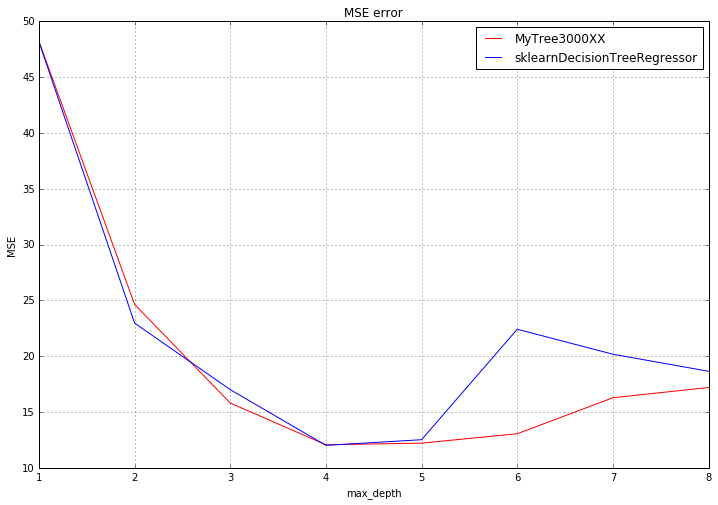

In [311]:
X = np.arange(1,9)
plt.figure(figsize=(12,8))
plt.grid(True)
plt.title('MSE error')
plt.plot(X,my_var,color='red',label='MyTree3000XX')
plt.plot(X,classic_var,color='blue',label='sklearnDecisionTreeRegressor')
plt.xlabel('max_depth')
plt.ylabel('MSE')
plt.legend(loc='best')
plt.show()


Результаты сравнения деревеьев:

 - Ошибка MSE на кросс-валидации на глубине $max\_depth \leq 5$ почти одинакова, при $max\_depth = 6,7$ ошибка у дерева sklearn немного больше.
 - При больших значениях $max\_depth$ самодельное дерево работает слишком долго для тестирования.
